I have been interested in looking at MLB pitch data and play-by-play for a while now, however, I have not found any good blob posts or tutorials for doing this. So during the MLB Playoffs, while I was checking the score of [Cubs vs. Dodgers, Game 5](http://sports.yahoo.com/mlb/chicago-cubs-los-angeles-dodgers-361020119/) on Yahoo! it struck me that there is proabably a way to get the live game data from Yahoo! while the game is in progress.  So I poked arond and found that there is! In this post, I will review what I found and how to use the data to make pitch charts using the data from [World Series Game 7](http://sports.yahoo.com/mlb/chicago-cubs-cleveland-indians-361102105/).

Yahoo! gives every game a _gameid_. For World Series Game 7, the _gameid_ is:

In [5]:
game_id = '361102105'

The game boxscore data that you see on Yahoo! can be accessed in real-time here:

In [6]:
game_url = 'https://api-secure.sports.yahoo.com/v1/editorial/s/boxscore/mlb.g.' + game_id + \
            '?lang=en-US&region=US&tz=America%2FChicago&ysp_redesign=1&mode=&v=4&ysp_enable_last_update=1&polling=1'

Using [_requests_](http://docs.python-requests.org/en/master/), we can get the boxscore data.

In [7]:
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.10; rv:39.0) Gecko/20100101 Firefox/39.0'}
response = requests.get(game_url, headers=headers)
game_data = response.json()

Exploring the boxscore, there is a _gamepitches_ record. This is Yahoo!'s pitch data.

In [8]:
pitches = game_data['service']['boxscore']['gamepitches']['mlb.g.'+game_id]

I printed out how many pitches were thrown in Game 7.

In [9]:
print("Total number of pitches thrown during the game: " + str(len(pitches)))

Total number of pitches thrown during the game: 343


I pushed the pitch data into a pandas data frame.

In [10]:
import pandas as pd
pitch_df = pd.DataFrame(pitches)
pitch_df.head()

,10010100,10010200,10010300,10010400,10010500,10010600,10020100,10020200,10020300,10020400,...,9040300,9040400,9040500,9040600,9050100,9050200,9050300,9050400,9050500,9050600
balls,0,1,1,1,2,2,0,0,0,1,...,1,1,1,2,0,0,1,1,2,3
batter,9604,9604,9604,9604,9604,9604,6956,6956,6956,6956,...,8853,8853,8853,8853,9116,9116,9116,9116,9116,9116
game,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105,...,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105,361102105
horizontal,11667,-5000,-8333,16667,-1667,5000,8333,13333,-15000,0,...,10000,10000,15000,10000,5000,5000,-8333,15000,-6667,11667
period,10,10,10,10,10,10,10,10,10,10,...,9,9,9,9,9,9,9,9,9,9


I transposed the data frame so that the columns corresponded to the pitch variables such as _balls_, _strikes_, and _velocity_.

In [11]:
transpose_pitch_df = pitch_df.transpose()
transpose_pitch_df.head()

,balls,batter,game,horizontal,period,pitch_num,pitch_type,pitcher,play_num,play_type,result,sequence,strikes,velocity,vertical
10010100,0,9604,361102105,11667,10,1,3,7847,10010100,PITCH,0,1,0,82,3333
10010200,1,9604,361102105,-5000,10,2,3,7847,10010200,PITCH,1,2,0,81,-3333
10010300,1,9604,361102105,-8333,10,3,1,7847,10010300,PITCH,2,3,1,91,13333
10010400,1,9604,361102105,16667,10,4,3,7847,10010400,PITCH,0,4,2,83,-13333
10010500,2,9604,361102105,-1667,10,5,3,7847,10010500,PITCH,3,5,2,82,-6667


The data in the pitch data frame are all strings. I needed to convert numeric fields to numeric data types.

In [12]:
for val in list(transpose_pitch_df.columns.values):
    transpose_pitch_df[val] = transpose_pitch_df[val].convert_objects(convert_numeric=True)
    
transpose_pitch_df.dtypes

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


balls           int64
batter          int64
game            int64
horizontal    float64
period          int64
pitch_num       int64
pitch_type    float64
pitcher         int64
play_num        int64
play_type      object
result          int64
sequence        int64
strikes         int64
velocity      float64
vertical      float64
dtype: object

Using [_BeautifulSoup_](https://www.crummy.com/software/BeautifulSoup/), I retrieved the names of the pitchers and batters from their Yahoo! ID.

In [13]:
from bs4 import BeautifulSoup

I verified the starting pitcher and lead-off batter for Game 7.

In [14]:
pitcher_url = 'http://sports.yahoo.com/mlb/players/' + str(transpose_pitch_df['pitcher']['10100']) + '/'
req = requests.get(pitcher_url)
html = req.text
soup = BeautifulSoup(html, 'html.parser')
print("On the mound to start the game: " + soup.title.string)
batter_url = 'http://sports.yahoo.com/mlb/players/' + str(transpose_pitch_df['batter']['10100']) + '/'
req = requests.get(batter_url)
html = req.text
soup = BeautifulSoup(html, 'html.parser')
print("First batter faced: " + soup.title.string)

On the mound to start the game: Corey Kluber | Cleveland | Major League Baseball | Yahoo! Sports
First batter faced: Dexter Fowler | Chi Cubs | Major League Baseball | Yahoo! Sports


I also listed the pitchers who played in Game 7.

In [15]:
pitcher_list = transpose_pitch_df.pitcher.unique()
for pitcher in pitcher_list:
    pitcher_url = 'http://sports.yahoo.com/mlb/players/' + str(pitcher) + '/'
    req = requests.get(pitcher_url)
    html = req.text
    soup = BeautifulSoup(html, 'html.parser')
    pitcher_info = soup.title.string
    print(pitcher_info.split('|')[0] + " of the " + 
          pitcher_info.split('|')[1] + "(Yahoo ID: "+str(pitcher)+")")

Andrew Miller  of the  Cleveland (Yahoo ID: 7847)
Corey Kluber  of the  Cleveland (Yahoo ID: 9048)
Kyle Hendricks  of the  Chi Cubs (Yahoo ID: 9758)
Jon Lester  of the  Chi Cubs (Yahoo ID: 7790)
Cody Allen  of the  Cleveland (Yahoo ID: 9243)
Aroldis Chapman  of the  Chi Cubs (Yahoo ID: 8616)
Bryan Shaw  of the  Cleveland (Yahoo ID: 8962)
Trevor Bauer  of the  Cleveland (Yahoo ID: 9122)
Carl Edwards Jr.  of the  Chi Cubs (Yahoo ID: 9555)
Mike Montgomery  of the  Chi Cubs (Yahoo ID: 8684)


I thought that Kluber and Hendricks were going to be in Game 7 a lot longer than they were. I filtered only to look only at their pitches.

In [16]:
kluber = transpose_pitch_df[transpose_pitch_df.pitcher == 9048]
hendricks = transpose_pitch_df[transpose_pitch_df.pitcher == 9758]

After filtering on only their pitches, I can create some pitch charts using [_matplotlib_](http://matplotlib.org/).

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

I plotted a histogram of Kluber's pitch velovity during game 7.

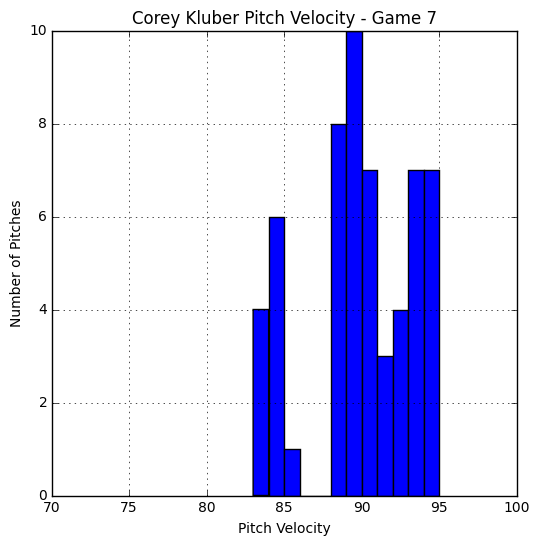

In [18]:
plt.figure(figsize=(6,6))
plt.subplot(111)
k_max = kluber.velocity.max()
k_min = kluber.velocity.min()
ax1= kluber['velocity'].hist(bins=k_max-k_min)
plt.xlim(70, 100)
plt.title('Corey Kluber Pitch Velocity - Game 7')
plt.xlabel('Pitch Velocity')
plt.ylabel('Number of Pitches')
plt.show()

I also created a histogram of Hendrick's pitch velocity during Game 7.

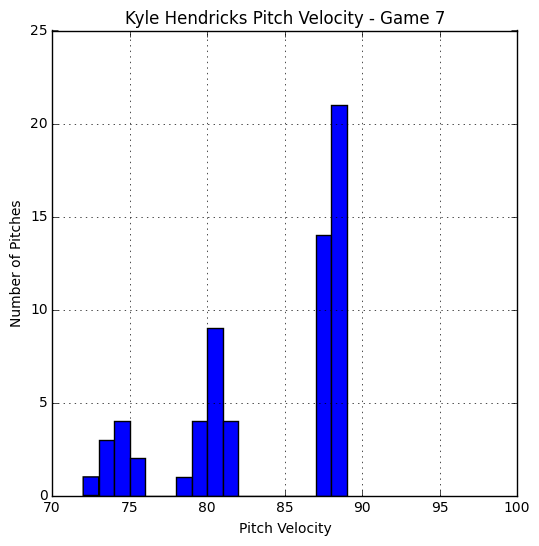

In [19]:
plt.figure(figsize=(6,6))
plt.subplot(111)
h_max = hendricks.velocity.max()
h_min = hendricks.velocity.min()
ax2 = hendricks['velocity'].hist(bins=h_max-h_min)
plt.xlim(70, 100)
plt.title('Kyle Hendricks Pitch Velocity - Game 7')
plt.xlabel('Pitch Velocity')
plt.ylabel('Number of Pitches')
plt.show()

Next, looked at pitch location. I seprated balls from strikes (strikes, fould balls, and hits) for each pitcher.

In [20]:
sorted_kluber_pitches = kluber.sort_values(['play_num'])
sorted_hendricks_pitches = hendricks.sort_values(['play_num'])
kluber_balls =sorted_kluber_pitches[sorted_kluber_pitches.result == 0]
hendricks_balls =sorted_hendricks_pitches[sorted_hendricks_pitches.result == 0]
kluber_others =sorted_kluber_pitches[sorted_kluber_pitches.result != 0]
hendricks_others =sorted_hendricks_pitches[sorted_hendricks_pitches.result != 0]

I plotted the pitch locations on using _matplotlib_ and _seaborn_.

In [21]:
import seaborn as sns

First, I checked to see if pitches that were balls formed the strike zone.

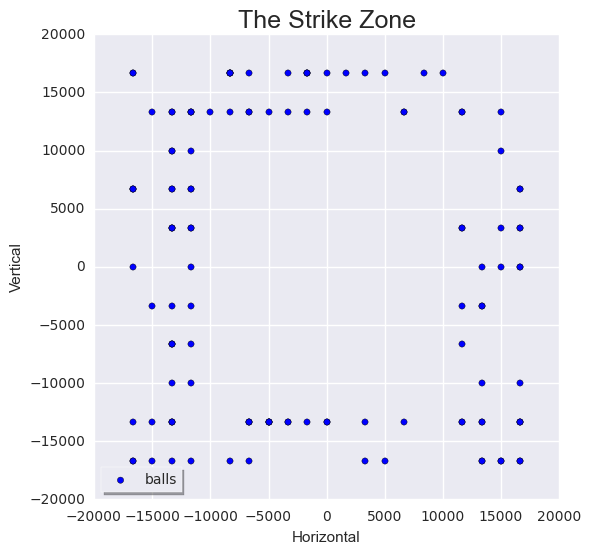

In [22]:
plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.scatter(transpose_pitch_df[transpose_pitch_df.result==0].horizontal, 
                    transpose_pitch_df[transpose_pitch_df.result==0].vertical, 
                    marker='o', label='balls')

ax.set_xlim(-20000,20000)
ax.set_ylim(-20000,20000)

#Axis labels
ax.set_xlabel('Horizontal')
ax.set_ylabel('Vertical')

#set title
ax.set_title('The Strike Zone', 
             y=1.0, fontsize=18)

#show legend
ax.legend(loc=3, frameon=True, shadow=True)
plt.show()

When I filtered to only show balls, you see a big gap in pitch locations. These points outline the strike zone.

I created the starting pitchers pitch charts. Here is Kyle Hendrick's.

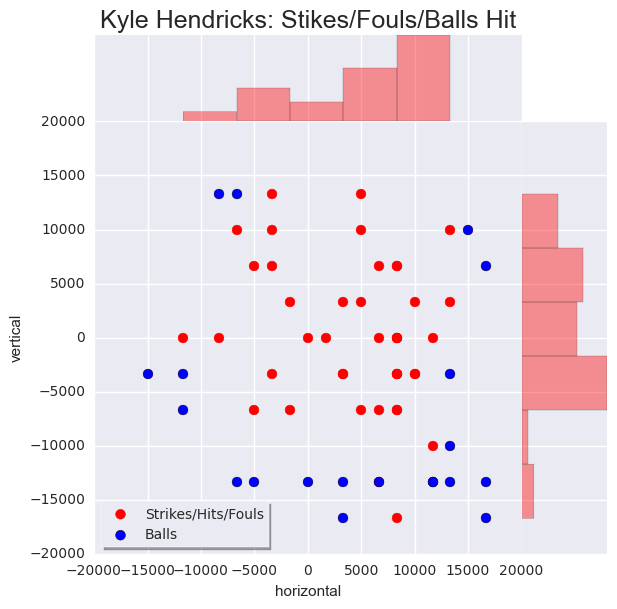

In [23]:
# create our jointplot
joint_chart = sns.jointplot(hendricks_others.horizontal,
                                 hendricks_others.vertical, 
                                 stat_func=None,
                                 color='r',
                                 marker='o',
                                 s=50,
                                 kind='scatter', 
                                 space=0,
                                 label='Strikes/Hits/Fouls',
                                 alpha=1.0)

joint_chart.fig.set_size_inches(6,6)

joint_chart.x = hendricks_balls.horizontal
joint_chart.y = hendricks_balls.vertical
joint_chart.plot_joint(plt.scatter, marker='o', 
                       c='b', s=50,label='Balls')

ax = joint_chart.ax_joint

ax.set_xlim(-20000,20000)
ax.set_ylim(-20000, 20000)

# Get rid of axis labels and tick marks
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.tick_params(labelbottom='off', labelleft='off')

# Add a title and legend
ax.set_title('Kyle Hendricks: Stikes/Fouls/Balls Hit', 
             y=1.2, fontsize=18)
ax.legend(loc=3, frameon=True, shadow=True)

# Add Data Scource and Author
#ax.text(-20000,-20000,'Data Source: Yahoo!'
#        '\nAuthor: Gregory Brunner, @gregbrunn',
#        fontsize=12)

plt.show()

Here is Corey Kluber's pitch chart.

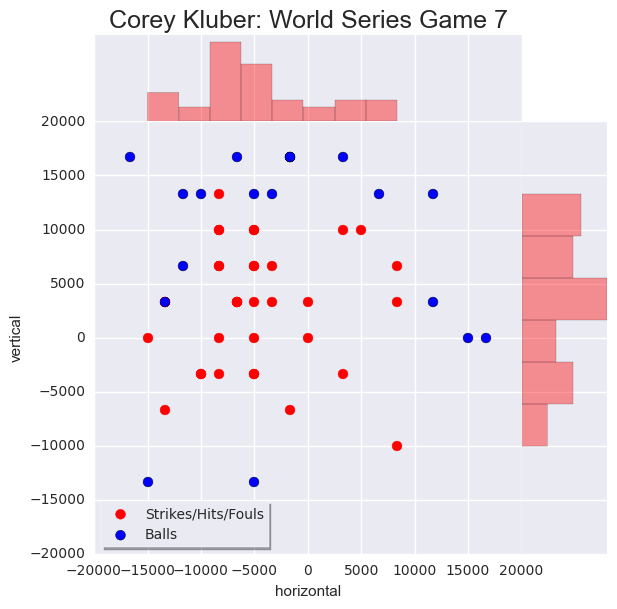

In [24]:
joint_chart = sns.jointplot(kluber_others.horizontal,
                                 kluber_others.vertical, 
                                 stat_func=None,
                                 color='r',
                                 marker='o',
                                 s=50,
                                 kind='scatter', 
                                 space=0, 
                                 label='Strikes/Hits/Fouls',
                                 alpha=1.0)

joint_chart.fig.set_size_inches(6,6)

joint_chart.x = kluber_balls.horizontal
joint_chart.y = kluber_balls.vertical
joint_chart.plot_joint(plt.scatter, marker='o', 
                       c='b', s=50,label='Balls')

ax = joint_chart.ax_joint

ax.set_xlim(-20000,20000)
ax.set_ylim(-20000, 20000)

# Get rid of axis labels and tick marks
#ax.set_xlabel('')
#ax.set_ylabel('')
#ax.tick_params(labelbottom='off', labelleft='off')

# Add a title and legend
ax.set_title('Corey Kluber: World Series Game 7', 
             y=1.2, fontsize=18)
ax.legend(loc=3, frameon=True, shadow=True)


# Add Data Scource and Author
#ax.text(-20000,-20000,'Data Source: Yahoo!'
#        '\nAuthor: Gregory Brunner, @gregbrunn',
#        fontsize=12)

plt.show()

This is a really cursory analysis of the pitch data. There is a lot more I could do, but I'll save that for another day.

What I hope to do in a future post is look at the play-by-play data and plot hit locations on [Gavin's](https://twitter.com/gavinrehkemper) [team basemaps](https://gavinr.github.io/team-basemaps/)! If you are interesed in doing this yourself, here is how you can access the hit locations.

In [25]:
play_by_play = game_data['service']['boxscore']['gameplay_by_play']['mlb.g.'+game_id]
play_by_play_df = pd.DataFrame(play_by_play)
play_by_play_df.transpose().head()

,away_score,ball_hit,batter,errors,hit_angle,hit_distance,hit_hardness,hit_style,hits,home_score,period,pitcher,pitches_ids,play_num,play_time,play_type,players,runs,text
10010601,NaN,1,9604,NaN,47,78,2,5,NaN,NaN,10,7847,"10010100,10010200,10010300,10010400,10010500,1...",10010601,1478138751,RESULT,9604,NaN,[mlb.p.9604] fouled out to first
10020401,6,1,6956,NaN,6,402,3,2,NaN,3,10,7847,"10020100,10020200,10020300,10020400",10020401,1478138866,RESULT,6956,1,[mlb.p.6956] homered (402 ft.) to deep center
10030201,NaN,1,8621,NaN,35,110,2,3,NaN,NaN,10,7847,"10030100,10030200",10030201,1478138929,RESULT,8621,NaN,[mlb.p.8621] grounded out to first
10040401,NaN,0,9557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,7847,"10040100,10040200,10040300,10040400",10040401,1478139030,RESULT,9557,NaN,[mlb.p.9557] struck out swinging
1010101,NaN,1,8619,NaN,23,262,3,4,NaN,NaN,1,9758,1010100,1010101,1478132159,RESULT,8619,NaN,[mlb.p.8619] lined out to right
